In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/extracted-data1/extracted_data/mask/001_frame0029_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/001_frame0060_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/002_frame0078_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/002_frame0077_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/002_frame0146_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/001_frame0061_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/002_frame0216_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/002_frame0068_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/002_frame0120_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/001_frame0074_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/002_frame0117_GroundTruth_color.png
/kaggle/input/extracted-data1/extracted_data/mask/002_

In [3]:
!pip install torchinfo
from zipfile import ZipFile

In [4]:
import os

# Set the path to the extracted dataset
data_path = '/kaggle/input/extracted-data1'

# Check if the dataset path exists and list its contents
if os.path.exists(data_path):
    print("Dataset path found!")
    print("Contents:", os.listdir(data_path))
else:
    print("Dataset path not found. Please check the path.")


Dataset path found!
Contents: ['extracted_data']


In [5]:
import torch
import torch.nn as nn# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchinfo import summary

import os
import warnings
warnings.filterwarnings('ignore')
import zipfile

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SPLIT = 0.7
LR = 3e-4
PATH = '/kaggle/input/extracted-data1/extracted_data'

In [7]:
DEVICE

'cuda'

In [8]:
class UAVDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB") # multi-channel segmentation

        # using random library to ensure image and mask pairs have the same transformations

        if random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        if random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        if random() > 0.8:
            image = TF.rotate(image, 30)
            mask = TF.rotate(mask, 30)

        image = TF.to_tensor(image)
        image = TF.resize(image,size = (572,572))
        mask = TF.to_tensor(mask)
        mask = TF.resize(mask,size = (274,274))
        return image, mask

In [9]:
os.getcwd()

'/kaggle/working'

In [10]:
os.makedirs('/kaggle/working/saved_model', exist_ok = True) # create library to store saved models

In [11]:
img_dir = PATH + '/image'
mask_dir = PATH + '/mask'
save_model_path = '/kaggle/working/saved_model'

In [12]:
img_dir, mask_dir, save_model_path

('/kaggle/input/extracted-data1/extracted_data/image',
 '/kaggle/input/extracted-data1/extracted_data/mask',
 '/kaggle/working/saved_model')

In [13]:
data = UAVDataset(img_dir = img_dir, mask_dir = mask_dir)

In [14]:

data.__len__()

215

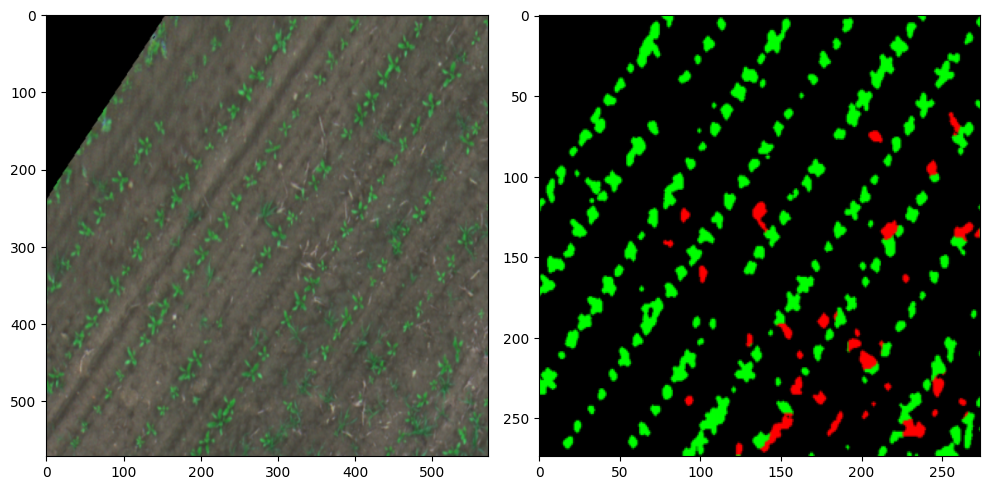

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
image, mask = data[8]
ax[0].imshow(image.permute(1,2,0))
ax[1].imshow(mask.permute(1,2,0))
plt.tight_layout()

In [16]:
image.shape

torch.Size([3, 572, 572])

In [17]:
mask.shape

torch.Size([3, 274, 274])

In [18]:
train_size = int(len(data)*SPLIT)
test_size = len(data) - train_size

trainData, testData = random_split(data, [train_size, test_size])

In [19]:
len(trainData), len(testData)

(150, 65)

In [20]:
trainDL = DataLoader(trainData, batch_size = 8, shuffle = True)
testDL = DataLoader(testData, batch_size = 8, shuffle = False)

In [21]:
len(trainDL), len(testDL)

(19, 9)

In [22]:
for batch in trainDL:
    img, mask = batch
    print(img.size())
    print(mask.size())
    break


torch.Size([8, 3, 572, 572])
torch.Size([8, 3, 274, 274])


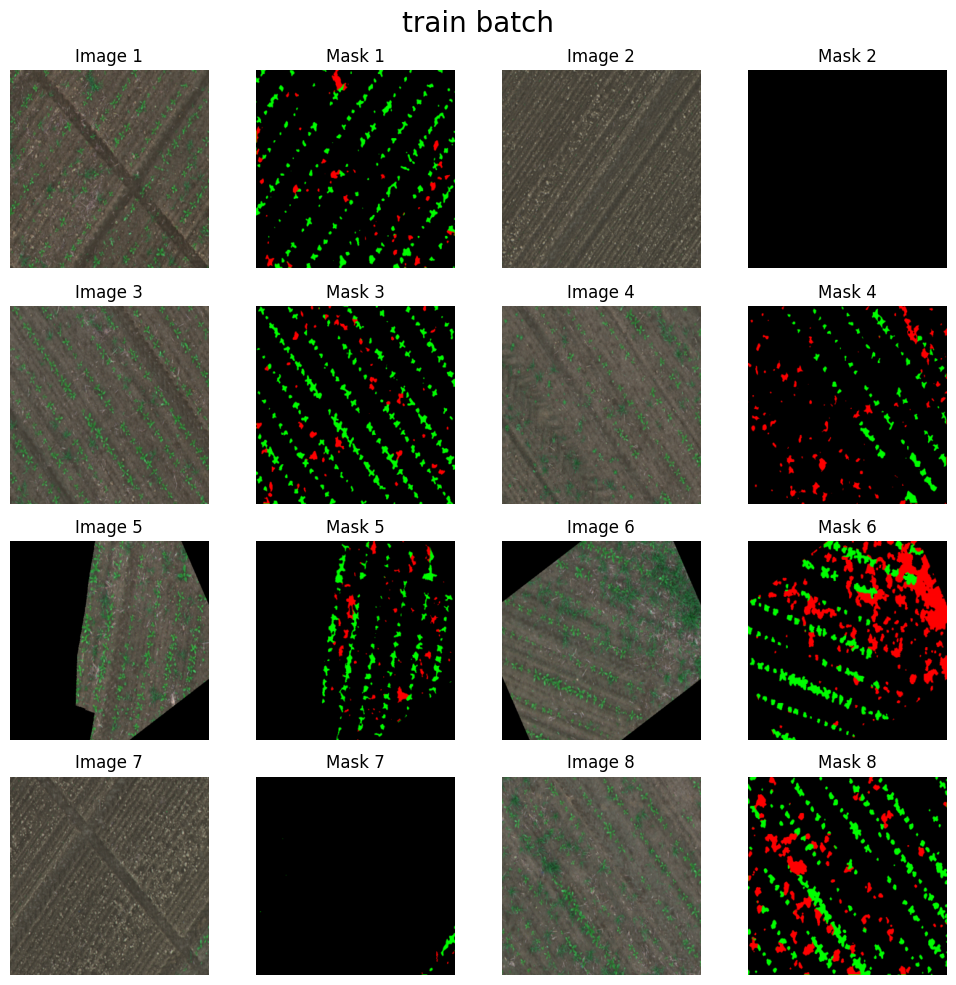

In [23]:
# plot image, mask pairs of the first training batch
for batch_idx, (images, masks) in enumerate(trainDL):
    if batch_idx == 0:
        fig, axs = plt.subplots(4, 4, figsize=(10,10))
        axs = axs.flatten()
        j = 0
        for i in range(8):
            img_np = TF.to_pil_image(images[i])
            mask_np = TF.to_pil_image(masks[i])

            # Plot the image
            axs[j].imshow(img_np)
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')

            # Plot the corresponding mask
            axs[j+1].imshow(mask_np, cmap='gray')
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Mask {i+1}')
            j += 2

        plt.suptitle('train batch', size = 20)
        plt.tight_layout()

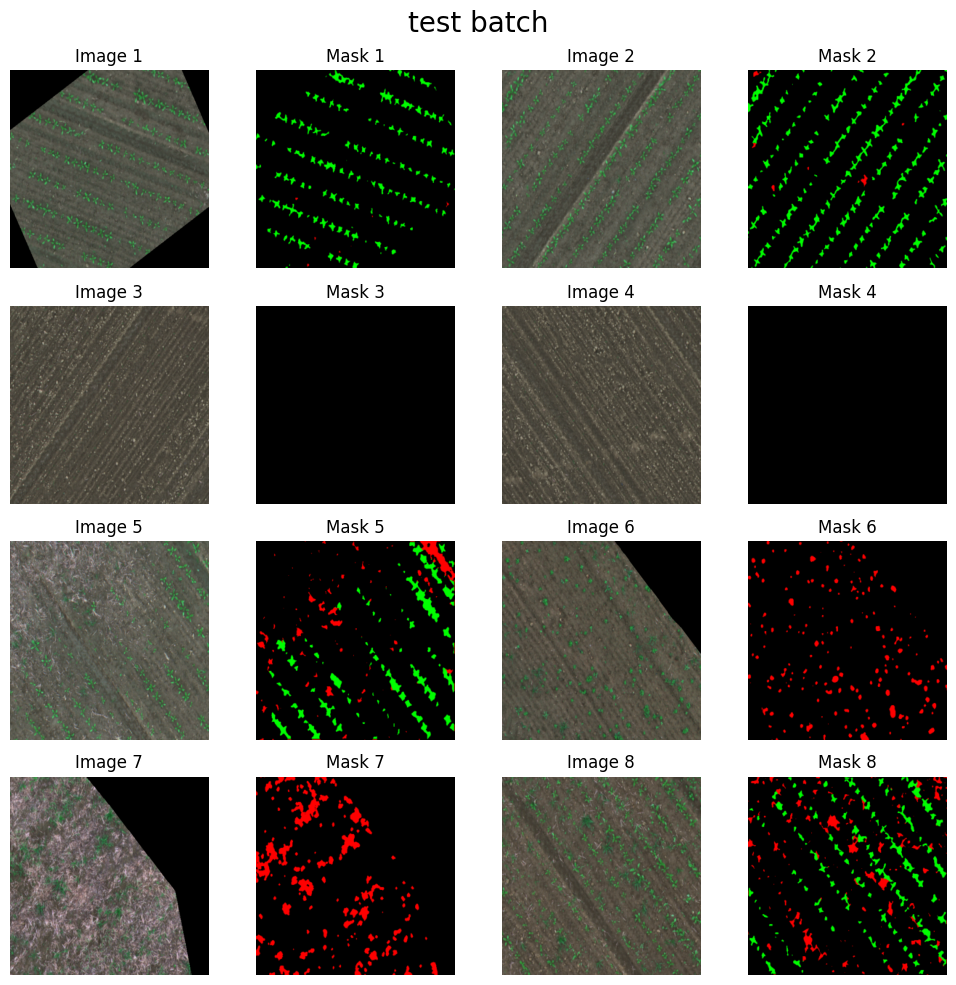

In [24]:
# plot image, mask pairs of the first test batch
for batch_idx, (images, masks) in enumerate(testDL):

    if batch_idx == 0:

        fig, axs = plt.subplots(4, 4, figsize=(10, 10))
        axs = axs.flatten()
        j=0
        for i in range(8):
            img_np = TF.to_pil_image(images[i])
            mask_np = TF.to_pil_image(masks[i])

            # Plot the image
            axs[j].imshow(img_np)
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')

            # Plot the corresponding mask
            axs[j+1].imshow(mask_np, cmap='gray')
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Mask {i+1}')
            j += 2

        plt.suptitle('test batch', size = 20)
        plt.tight_layout()

In [25]:
''' def crop_image(tensor,target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    val = 0
    if(delta%2 != 0):
      val = 1

    delta = delta // 2
    if(val == 1):
      return tensor[:,:,delta:tensor_size-delta-1,delta:tensor_size-delta-1]
    return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta] '''

import torch.nn.functional as F

def crop_image(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = target_size - tensor_size
    padding = [0, 0, 0, 0]  # padding values for top, bottom, left, right

    if delta > 0:
        pad_left = delta // 2
        pad_right = delta - pad_left
        padding = [pad_left, pad_right, pad_left, pad_right]

    return F.pad(tensor, padding)

In [26]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        resnet = models.resnet50(pretrained=True)  # Load pre-trained ResNet50

        # Encoder
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder
        self.up_conv_1 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder_conv_1 = DoubleConv(2048, 1024)

        self.up_conv_2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder_conv_2 = DoubleConv(1024, 512)

        self.up_conv_3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_conv_3 = DoubleConv(512, 256)

        self.up_conv_4 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.decoder_conv_4 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64,3,kernel_size=1)

    def forward(self, x):

      # Encoder


      x1 = self.encoder1(x)
      x2 = self.encoder2(x1)
      x3 = self.encoder3(x2)
      x4 = self.encoder4(x3)
      x5 = self.encoder5(x4)


      # Decoder
      x = self.up_conv_1(x5)
      y = crop_image(x4,x)
      x = self.decoder_conv_1(torch.cat([x,y],1))


      x = self.up_conv_2(x)
      y = crop_image(x,x3)
      x = self.decoder_conv_2(torch.cat([x3,y],1))


      x = self.up_conv_3(x)
      y = crop_image(x,x2)
      x = self.decoder_conv_3(torch.cat([x2,y],1))


      x = self.up_conv_4(x)
      y = crop_image(x1,x)
      x = self.decoder_conv_4(torch.cat([x,y],1))

      x = self.out(x)

      return x

# Define the double convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)



In [27]:
# ensure predicted mask & actual mask have equal dimensions
for batch in trainDL:
    img, mask = batch
    print(mask.shape)
    break
model = UNet().to(DEVICE)
x = img[0].unsqueeze(0).to(DEVICE)
pred = model(x)

print(x.shape)
print(pred.shape)

torch.Size([8, 3, 274, 274])


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s] 


torch.Size([1, 3, 572, 572])
torch.Size([1, 3, 274, 274])


In [28]:
loss_criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [29]:
summary(model, [16, 3, 572, 572])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 3, 274, 274]         --
├─Sequential: 1-1                        [16, 64, 143, 143]        --
│    └─Conv2d: 2-1                       [16, 64, 286, 286]        9,408
│    └─BatchNorm2d: 2-2                  [16, 64, 286, 286]        128
│    └─ReLU: 2-3                         [16, 64, 286, 286]        --
│    └─MaxPool2d: 2-4                    [16, 64, 143, 143]        --
├─Sequential: 1-2                        [16, 256, 143, 143]       --
│    └─Bottleneck: 2-5                   [16, 256, 143, 143]       --
│    │    └─Conv2d: 3-1                  [16, 64, 143, 143]        4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 143, 143]        128
│    │    └─ReLU: 3-3                    [16, 64, 143, 143]        --
│    │    └─Conv2d: 3-4                  [16, 64, 143, 143]        36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 143, 143]        128
│ 

In [30]:
DEVICE

'cuda'

In [31]:
def train_loop(epochs, model, trainDL, testDL, optimizer, loss_criteria):
    trainLossCount = []
    testLossCount = []
    device = next(model.parameters()).device 
    best_test_loss = 10000000
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0

        for batch_idx, (img, mask) in enumerate(trainDL):
            #print(f"Train Batch: {batch_idx}")
            img = img.to(device)
            mask = mask.to(device)
            model.train()
            optimizer.zero_grad()
            pred = model(img)
            loss = loss_criteria(pred, mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(trainDL)

        trainLossCount.append(train_loss)

        with torch.no_grad():
            
            for test_batch_idx, (test_img, test_mask) in enumerate(testDL):
                #print(f"Test Batch: {test_batch_idx}")
                test_img = test_img.to(device)
                test_mask = test_mask.to(device)
                test_pred = model(test_img)
                test_loss += loss_criteria(test_pred, test_mask)

            test_loss /= len(testDL)

            testLossCount.append(test_loss)

        if epoch % 1 == 0:
            print(f"Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")
            if test_loss < best_test_loss:
                print(f"Saving the model. Previous Best Test Loss: {best_test_loss}, Current Test Loss: {test_loss}")
                best_test_loss = test_loss
                torch.save(model.state_dict(), os.path.join(save_model_path, 'model.pth'))

    return trainLossCount, testLossCount

In [32]:
!pip install torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 8.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 81.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.3 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [33]:
import torch
print("CUDA available:", torch.cuda.is_available())


CUDA available: True


In [46]:
model = model.to("cuda:0")

In [35]:
trainLossCount, testLossCount = train_loop(100, model, trainDL, testDL, optimizer, loss_criteria)

Epoch: 0, Train Loss: 0.5805297023371646, Test Loss: 0.502247154712677
Saving the model. Previous Best Test Loss: 10000000, Current Test Loss: 0.502247154712677
Epoch: 1, Train Loss: 0.48222846106479045, Test Loss: 0.4581374228000641
Saving the model. Previous Best Test Loss: 0.502247154712677, Current Test Loss: 0.4581374228000641
Epoch: 2, Train Loss: 0.43716456231318024, Test Loss: 0.41497600078582764
Saving the model. Previous Best Test Loss: 0.4581374228000641, Current Test Loss: 0.41497600078582764
Epoch: 3, Train Loss: 0.39870160190682663, Test Loss: 0.3817618787288666
Saving the model. Previous Best Test Loss: 0.41497600078582764, Current Test Loss: 0.3817618787288666
Epoch: 4, Train Loss: 0.3708510226324985, Test Loss: 0.35156717896461487
Saving the model. Previous Best Test Loss: 0.3817618787288666, Current Test Loss: 0.35156717896461487
Epoch: 5, Train Loss: 0.338705870666002, Test Loss: 0.3226030468940735
Saving the model. Previous Best Test Loss: 0.35156717896461487, Curre

In [36]:
testLossCount_numpy = []
for loss_tensor in testLossCount:
    # Convert each tensor to a NumPy value
    loss_value = loss_tensor.cpu().numpy()
    testLossCount_numpy.append(loss_value)

# Now testLossCount_numpy is a list of NumPy values representing test losses
print(testLossCount_numpy)

[array(0.50224715, dtype=float32), array(0.45813742, dtype=float32), array(0.414976, dtype=float32), array(0.38176188, dtype=float32), array(0.35156718, dtype=float32), array(0.32260305, dtype=float32), array(0.29614812, dtype=float32), array(0.27245823, dtype=float32), array(0.24990517, dtype=float32), array(0.22923885, dtype=float32), array(0.21148871, dtype=float32), array(0.19576207, dtype=float32), array(0.18202357, dtype=float32), array(0.16900618, dtype=float32), array(0.1580493, dtype=float32), array(0.14746682, dtype=float32), array(0.13754599, dtype=float32), array(0.12901767, dtype=float32), array(0.12040652, dtype=float32), array(0.11395676, dtype=float32), array(0.106792, dtype=float32), array(0.09978397, dtype=float32), array(0.09466776, dtype=float32), array(0.08893523, dtype=float32), array(0.08639114, dtype=float32), array(0.08006234, dtype=float32), array(0.07554326, dtype=float32), array(0.07134519, dtype=float32), array(0.06786754, dtype=float32), array(0.06651716, 

In [37]:
testLossList = [loss.tolist() for loss in testLossCount_numpy]


In [38]:
# save loss metrics from training
assert(len(trainLossCount) == len(testLossCount))
np.savez(os.path.join(save_model_path, 'lossCounts'), trainLossCount = trainLossCount, testLossList = testLossList)


In [39]:
load_loss_path ='/kaggle/working/saved_model'
losses = np.load(os.path.join(load_loss_path, 'lossCounts.npz'))

In [40]:
finalTrainLoss = losses['trainLossCount']
finalTestLoss = losses['testLossList']

In [41]:
finalTrainLoss

array([0.5805297 , 0.48222846, 0.43716456, 0.3987016 , 0.37085102,
       0.33870587, 0.3104626 , 0.28531009, 0.26255465, 0.24118123,
       0.22176346, 0.20527042, 0.19039392, 0.17665154, 0.16486226,
       0.15435685, 0.14352661, 0.13461861, 0.12599783, 0.1186909 ,
       0.11244233, 0.10622008, 0.09959601, 0.09462855, 0.08733663,
       0.0841404 , 0.07923557, 0.07552897, 0.07004986, 0.06826931,
       0.06791153, 0.06190774, 0.05870387, 0.05723028, 0.05489995,
       0.05389567, 0.05134605, 0.04926983, 0.04807239, 0.04536162,
       0.04446814, 0.04339991, 0.04267011, 0.04232422, 0.0408672 ,
       0.03929572, 0.03787364, 0.03780243, 0.03672392, 0.03597323,
       0.0353045 , 0.03485915, 0.03460958, 0.03356255, 0.0333604 ,
       0.03305814, 0.0329647 , 0.03112484, 0.03103763, 0.03185067,
       0.03072845, 0.0311438 , 0.02945797, 0.02941967, 0.02876705,
       0.02888334, 0.02991524, 0.02884467, 0.02762167, 0.02736843,
       0.02678612, 0.02746598, 0.02744339, 0.0264652 , 0.02618

In [42]:
finalTestLoss

array([0.50224715, 0.45813742, 0.414976  , 0.38176188, 0.35156718,
       0.32260305, 0.29614812, 0.27245823, 0.24990517, 0.22923885,
       0.21148871, 0.19576207, 0.18202357, 0.16900618, 0.1580493 ,
       0.14746682, 0.13754599, 0.12901767, 0.12040652, 0.11395676,
       0.106792  , 0.09978397, 0.09466776, 0.08893523, 0.08639114,
       0.08006234, 0.07554326, 0.07134519, 0.06786754, 0.06651716,
       0.06344855, 0.05989613, 0.05634983, 0.0548679 , 0.05412477,
       0.05171336, 0.05070883, 0.04756363, 0.04740934, 0.04560307,
       0.04433991, 0.04261218, 0.04257934, 0.04129133, 0.0409571 ,
       0.03979007, 0.03856746, 0.0389181 , 0.03674762, 0.03655656,
       0.03732112, 0.03543304, 0.03530417, 0.03570798, 0.03341216,
       0.03326302, 0.03446667, 0.03238724, 0.0332252 , 0.03265405,
       0.03293541, 0.0313315 , 0.03103573, 0.03097508, 0.03136005,
       0.03151179, 0.03080659, 0.03019404, 0.02987702, 0.02959392,
       0.02936288, 0.03109019, 0.03005574, 0.02932771, 0.02901

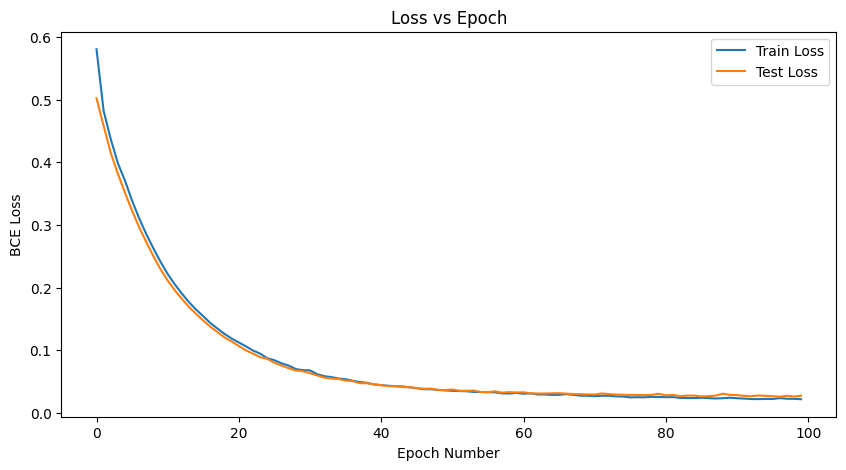

In [43]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(0, len(finalTrainLoss))], finalTrainLoss, label = 'Train Loss')
plt.plot([i for i in range(0, len(finalTestLoss))], finalTestLoss, label = 'Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('BCE Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

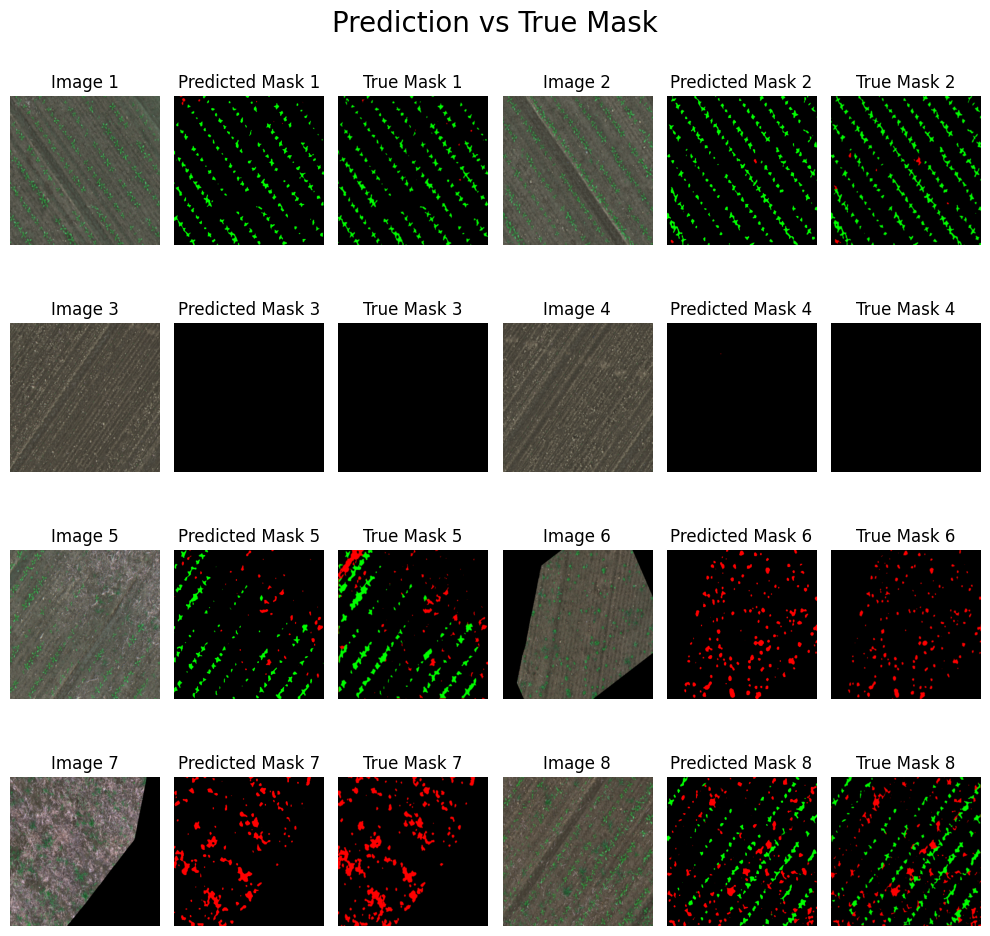

In [47]:
# plot test_batch with true / predicted masks
model = model.to("cuda:1")
for batch_idx, (image, true_mask) in enumerate(testDL):
    
    image = image.to("cuda:1")
    true_mask = true_mask.to("cuda:1")
    if batch_idx == 0:
        fig, axs = plt.subplots(4, 6, figsize = (10,10))
        axs = axs.flatten()
        pred_mask = model(image)
        j = 0
        for i in range(8):
            
            # Plot the image
            axs[j].imshow(image[i].detach().cpu().numpy().transpose(1,2,0))
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')
            
            # Plot the predicted mask
            axs[j+1].imshow(pred_mask[i].detach().cpu().numpy().transpose(1,2,0))
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Predicted Mask {i+1}')

            # Plot the corresponding mask
            axs[j+2].imshow(true_mask[i].detach().cpu().numpy().transpose(1,2,0))
            axs[j+2].axis('off')
            axs[j+2].set_title(f'True Mask {i+1}')
            j += 3

        plt.suptitle('Prediction vs True Mask', size = 20)
        plt.tight_layout()
        
        
        